In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
from sklearn.svm import NuSVC, SVC
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# data loading

In [150]:

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon/FshionProductReviews_V5_NLP.csv')
dataset

,overall,verified,reviewTime,reviewText,summary,length,sentiment
0,2,True,2014-09-28,agree opening small bent hook expensive earr...,"I agree with the other review, the opening is ...",48,0
1,2,True,2014-08-24,tiny opening,Two Stars,4,0
2,4,True,2014-05-31,little plastic back work great loosing hook ...,Works great!,28,1
3,3,True,2013-09-22,mother law wanted present sister d work,bought as a present,21,0
4,3,True,2013-07-17,look s stretched carefully push case ...,Buxton heiress collection,68,0
...,...,...,...,...,...,...,...
658179,5,True,2017-02-21,absolutely love s sexy comfortable split mu...,I absolutely love this dress,48,1
658180,5,True,2016-11-25,m lb m tall large large comfortable amount ...,I wear a large and ordered a large and it stil...,37,1
658181,3,True,2016-11-10,big chest area,Three Stars,6,0
658182,3,True,2016-11-10,clear need lining,Three Stars,7,0


In [151]:
dataset.isnull().sum()

overall          0
verified         0
reviewTime       0
reviewText    1593
summary          3
length           0
sentiment        0
dtype: int64

In [152]:
dataset.dropna(axis=0, inplace=True)

In [153]:
dataset.isnull().sum()

overall       0
verified      0
reviewTime    0
reviewText    0
summary       0
length        0
sentiment     0
dtype: int64

# data split

In [154]:
dev = pd.concat(
    [dataset[dataset['sentiment']==0].head(5000), dataset[dataset['sentiment']==1].head(5000)], axis=0
)[['reviewText', 'sentiment']]
dev

,reviewText,sentiment
0,agree opening small bent hook expensive earr...,0
1,tiny opening,0
3,mother law wanted present sister d work,0
4,look s stretched carefully push case ...,0
6,smoke s cigarette wo nt close disappointed,0
...,...,...
6259,hard finding good quality good quarter length...,1
6260,somewhat large s size good fit better ca nt...,1
6261,perfect,1
6262,father love,1


In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    dev[['reviewText']], dev.sentiment, test_size=0.2, random_state=33
)

# **Feature Extraction**

In [156]:
# Stopwords list

stop_words = set(stopwords.words('english'))
stop_words.update([
    "br","href", "http", "www",
  "ordered", 'bought', 'dress', 'order', 'color', 'shirt', 'one', 'tshirt', 'product',
  'item', 'would', 'could', 'make', 'fabric', 'jeans', 'sweater', 'jacket', 'pant', 'shoe', 'trouser', 
  'clothing', 'apparel', 'fashion''style', 'brand', 'collection', 'designer','season','trend','outfit',
  'accessory','runway','model','fabric','garment','store','shop','boutique','retail','customer','color'
  'size','material','design','look','dress','skirt','blouse','coat', 'accessory','jewelry','handbag','hat','scarf','sunglasses',
  'watch','makeup','hair','model','photography','influencer','marketing','promotion','sale','discount','price', 'wear', 'picture',
  'received', 'money', 'actually', 'almost', 'also', 'another',
       'arm', 'around', 'arrived', 'baby', 'back','bag', 'band', 'belt', 'bit', 'black', 'boot', 'bottom', 'came',
       'cant', 'come', 'costume', 'cover', 'cut', 'daughter', 'day', 'easy', 'enough', 'er', 'even', 'find'
       'first', 'foot', 'gave', 'get', 'gift', 'give', 'glass',
       'go', 'going', 'got', 'head', 'however', 'husband', 'im', 'ive', 'keep', 'know', 'made', 'make', 'many', 'month',
       'overall', 'pair', 'pant', 'part', 'piece',
       'pocket', 'purchase', 'purchased', 'purse','put', 'review', 'ring', 'run', 'said', 'say', 'see', 'seems',
       'shipping', 'shoe', 'short', 'side', 'since', 'sleeve', 'sock', 'something', 'son', 'stay', 'still', 'strap', 'sun',
       'support', 'theyre', 'thing', 'time', 'took', 'tried', 'true', 'two', 'use', 'wash',
       'way', 'week', 'white', 'without', 'woman', 'worn', 'xl', 'year'
])

In [157]:
vectorizer = TfidfVectorizer(
    min_df=0.01, max_features=200,
    stop_words=list(stop_words)
)
vectorizer.fit(X_train.reviewText)

TfidfVectorizer(max_features=200, min_df=0.01,
                stop_words=['store', 'retail', 'both', 'most', 'thing', 'y',
                            "shan't", 'accessory', 'you', 'through',
                            'ourselves', 'boutique', 'further', 'aren',
                            'enough', 'glass', 'they', 'sleeve', 'see',
                            'designer', 'http', 'herself', 'how', 'that',
                            'week', 'another', 'wash', 'now', "needn't", 'won', ...])

In [158]:
vectorizer.get_feature_names_out()

array(['already', 'always', 'amazon', 'arch', 'best', 'better', 'big',
       'bigger', 'brim', 'broke', 'buy', 'buying', 'ca', 'carhartt',
       'chain', 'cheap', 'child', 'comfortable', 'comfy', 'cool', 'cute',
       'definitely', 'disappointed', 'durable', 'ear', 'easily', 'ever',
       'every', 'exactly', 'excellent', 'expected', 'face', 'fall', 'far',
       'fast', 'feel', 'find', 'fine', 'first', 'fit', 'good', 'great',
       'halloween', 'happy', 'hard', 'high', 'kid', 'large', 'larger',
       'last', 'leg', 'length', 'light', 'like', 'little', 'long',
       'longer', 'looked', 'looking', 'loose', 'lot', 'love', 'loved',
       'maybe', 'medium', 'much', 'need', 'needed', 'never', 'new',
       'nice', 'nt', 'ok', 'old', 'party', 'perfect', 'perfectly',
       'plastic', 'probably', 'quality', 'quickly', 'quite', 'real',
       'really', 'recommend', 'return', 'returned', 'right', 'second',
       'seem', 'several', 'size', 'sizing', 'slip', 'small', 'smaller',
       'so

In [159]:
vectors = vectorizer.transform(X_train.reviewText).toarray()
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# PCA

In [160]:
pca = PCA(n_components=2)
pca.fit(vectors, dev.sentiment)

PCA(n_components=2)

In [161]:
features = pca.transform(vectors)

# Model

In [162]:
svc = SVC(
    C=2.5, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True,
    tol=0.001, cache_size=200, class_weight=None, verbose=True, max_iter=-1,
     decision_function_shape='ovr', break_ties=False, random_state=33
)
svc.fit(features, y_train)

[LibSVM]

SVC(C=2.5, probability=True, random_state=33, verbose=True)

In [163]:
ypred = svc.predict(features)
cm = confusion_matrix(y_pred=ypred, y_true=y_train)
cm

array([[3947,   52],
       [ 824, 3177]])

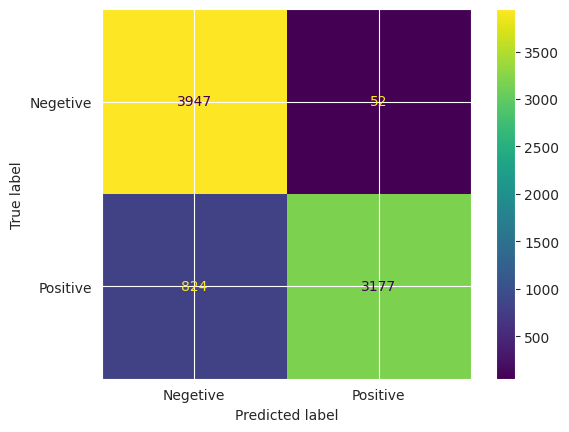

In [208]:
display = ConfusionMatrixDisplay(cm, display_labels=['Negetive', 'Positive'])
display.plot()

In [165]:
report = classification_report(
    y_pred=ypred, y_true=y_train
)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3999
           1       0.98      0.79      0.88      4001

    accuracy                           0.89      8000
   macro avg       0.91      0.89      0.89      8000
weighted avg       0.91      0.89      0.89      8000



# Model Visualization

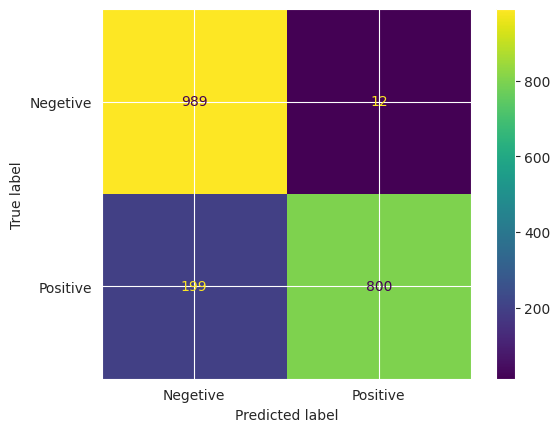

In [207]:
ypred_test = svc.predict(
    pca.transform(
        vectorizer.transform(
            X_test.reviewText).toarray()
            )
    )
cmt = confusion_matrix(y_pred=ypred_test, y_true=y_test)
displayT = ConfusionMatrixDisplay(cmt, display_labels=['Negetive', 'Positive'])
displayT.plot()

In [167]:
test_report = classification_report(
    y_pred=ypred_test, y_true=y_test
)
print(test_report)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1001
           1       0.99      0.80      0.88       999

    accuracy                           0.89      2000
   macro avg       0.91      0.89      0.89      2000
weighted avg       0.91      0.89      0.89      2000



In [170]:
features[:, 0].max(), features[:, 1].max()

(0.6625989344438282, 0.7475653580524515)

In [171]:
features[:, 0].min(), features[:, 1].min()

(-0.5567705216376619, -0.4993061232663712)

In [192]:
import matplotlib.pyplot as plt
sns.set_style(style='darkgrid')

# Generate some data points
X, y = dev.reviewText, dev.sentiment

# Fit the classifier to the data
svc.fit(features, y_train)

# Create a grid of points to evaluate the decision function on
xx, yy = np.meshgrid(np.linspace(features[:, 0].min(), features[:, 0].max(), 100),
                     np.linspace(features[:, 1].min(), features[:, 1].max(), 100))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the decision function on the grid of points
Z = svc.predict(X_grid)
Z = Z.reshape(xx.shape)
y_pred = svc.predict(features)


[LibSVM]

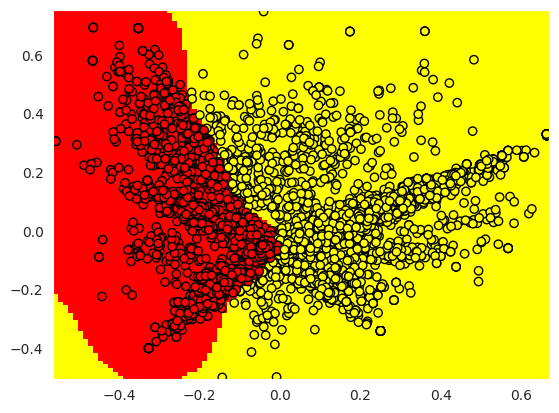

In [200]:
# Create a scatter plot of the data points, color-coded according to their true class labels
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap='autumn')
plt.scatter(features[:,0], features[:,1], c=y_pred, edgecolor='black',  cmap='autumn')
plt.show()


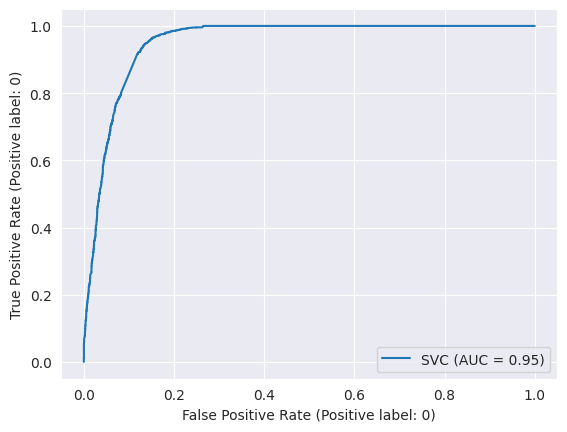

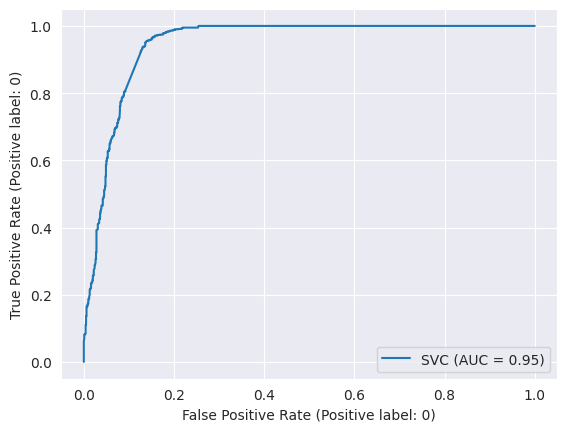

In [209]:
# ROC Curve
test_features = pca.transform(
        vectorizer.transform(
            X_test.reviewText).toarray()
            )
svc_disp1 = RocCurveDisplay.from_estimator(svc, features, y_train, pos_label=0)
svc_disp2 = RocCurveDisplay.from_estimator(svc, test_features, y_test, pos_label=0)
plt.show()

# Pipeline

In [ ]:
pipe = Pipeline(
    [
        ('tfidf', TfidfVectorizer(min_df=0.01, max_features=200,stop_words=list(stop_words))),
        ('pca', TruncatedSVD(n_components=2, random_state=33)),
        ('svc', SVC(
          C=2.5, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True,
          tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1,
          decision_function_shape='ovr', break_ties=False, random_state=33
        ))
    ], 
    verbose=True
)
pipe.fit(X_train.reviewText, y_train)

[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   5.1s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=200, min_df=0.01,
                                 stop_words=['store', 'retail', 'both', 'most',
                                             'thing', 'y', "shan't",
                                             'accessory', 'you', 'through',
                                             'ourselves', 'boutique', 'further',
                                             'aren', 'enough', 'glass', 'they',
                                             'sleeve', 'see', 'designer',
                                             'http', 'herself', 'how', 'that',
                                             'week', 'another', 'wash', 'now',
                                             "needn't", 'won', ...])),
                ('pca', TruncatedSVD(random_state=33)),
                ('svc', SVC(C=2.5, probability=True, random_state=33))],
         verbose=True)

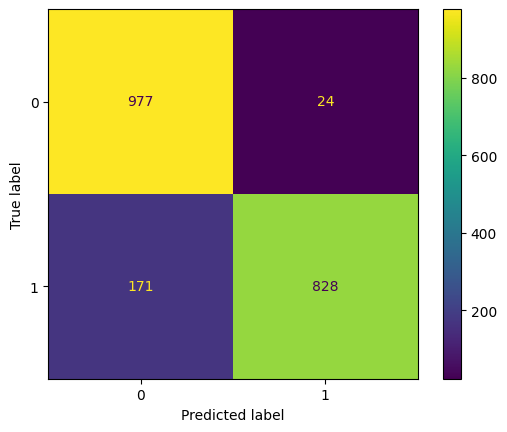

In [ ]:
ypred_test = pipe.predict(X_test.reviewText)
cmt = confusion_matrix(y_pred=ypred_test, y_true=y_test)
displayT = ConfusionMatrixDisplay(cmt, display_labels=svc.classes_)
displayT.plot()

In [ ]:
test_report = classification_report(
    y_pred=ypred_test, y_true=y_test
)
print(test_report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1001
           1       0.97      0.83      0.89       999

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



# Cross Validation

In [ ]:
# Load the iris dataset
X, y = dev.reviewText, dev.sentiment

# Create a KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=33)

# Create an empty list to store the accuracies of each fold
accuracies = []

# Loop through each fold and train a logistic regression model
for train_idx, test_idx in kf.split(X):
    X_train_cross, X_test_cross = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipe.fit(X_train_cross, y_train)
    
    # Calculate the accuracy on the test set and append it to the list
    accuracy = pipe.score(X_test_cross, y_test)
    accuracies.append(accuracy)

# Print the mean and standard deviation of the accuracies
print("Mean accuracy: {:.3f}".format(np.mean(accuracies)))
print("Standard deviation: {:.3f}".format(np.std(accuracies)))


[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   2.7s
[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   3.2s
[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   2.9s
[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   2.5s
[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipel

# Save Pipeline

In [ ]:
from joblib import dump, load

In [ ]:
dump(pipe, '/content/drive/MyDrive/Colab Notebooks/amazon/Pipeline.pkl')

['/content/drive/MyDrive/Colab Notebooks/amazon/Pipeline.pkl']